# Cluster the data and visualize
Following [this guide](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

In [1]:
!pip install scikit-learn matplotlib mplcursors ipympl python-dotenv openai langchain
!pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Importing required modules
from typing import List, Tuple
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import json
import cluster

file_path = f"data_store/embeddings_seed_69420_size_10000.json"
embeddings: List[Tuple[str, List[float]]] = json.load(open(file_path, "r"))

N_CLUSTERS = 10
N_DIMS = 128
SEED = 69420
df, label, u_labels = cluster.cluster(embeddings, n_clusters=N_CLUSTERS, dimensions=N_DIMS)

/home/lev/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
np.random.seed(SEED)
choices = np.random.choice(np.arange(len(df)), size=400)
colors = np.random.rand(N_CLUSTERS, 3)

In [4]:
%matplotlib ipympl
import textwrap
from mplcursors import cursor
import mplcursors
from matplotlib.text import Annotation

cmap = plt.cm.RdYlGn
norm = plt.Normalize(1,4)
c = np.random.randint(1,5,size=len(choices))

def plot_axis(dim : int):
    dim_1 = dim
    fig, ax = plt.subplots(figsize=(18,10))
    curr_ax = ax
    sc = curr_ax.scatter(df[choices, dim_1], np.zeros(len(choices)), color=colors[label[choices]])
    curr_ax.set_title(f"KMeans on Dimension {dim_1 + 1}")


    annot = curr_ax.annotate("", xy=(-0,0), xytext=(-80, 15), textcoords="offset points",
                    bbox=dict(boxstyle="round,pad=0.3", fc="w"),
                    arrowprops=dict(arrowstyle="->")
                    )
    annot.set_wrap(True)
    annot.set_visible(False)

    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([embeddings[n][0] for n in ind["ind"]]))
        wrapped_text = textwrap.fill(text, width=60)

        annot.set_text(wrapped_text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(1)


    def hover(event):
        # print("AAAA", event)
        vis = annot.get_visible()
        if event.inaxes is not None and event.inaxes == ax:
            # print("BBBB", event)
            # print(scs[0])
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    fig.canvas.mpl_connect("motion_notify_event", hover)

In [5]:
# print("\n".join(get_theorems_in_group(0)[:20]))
# print("\n\n")

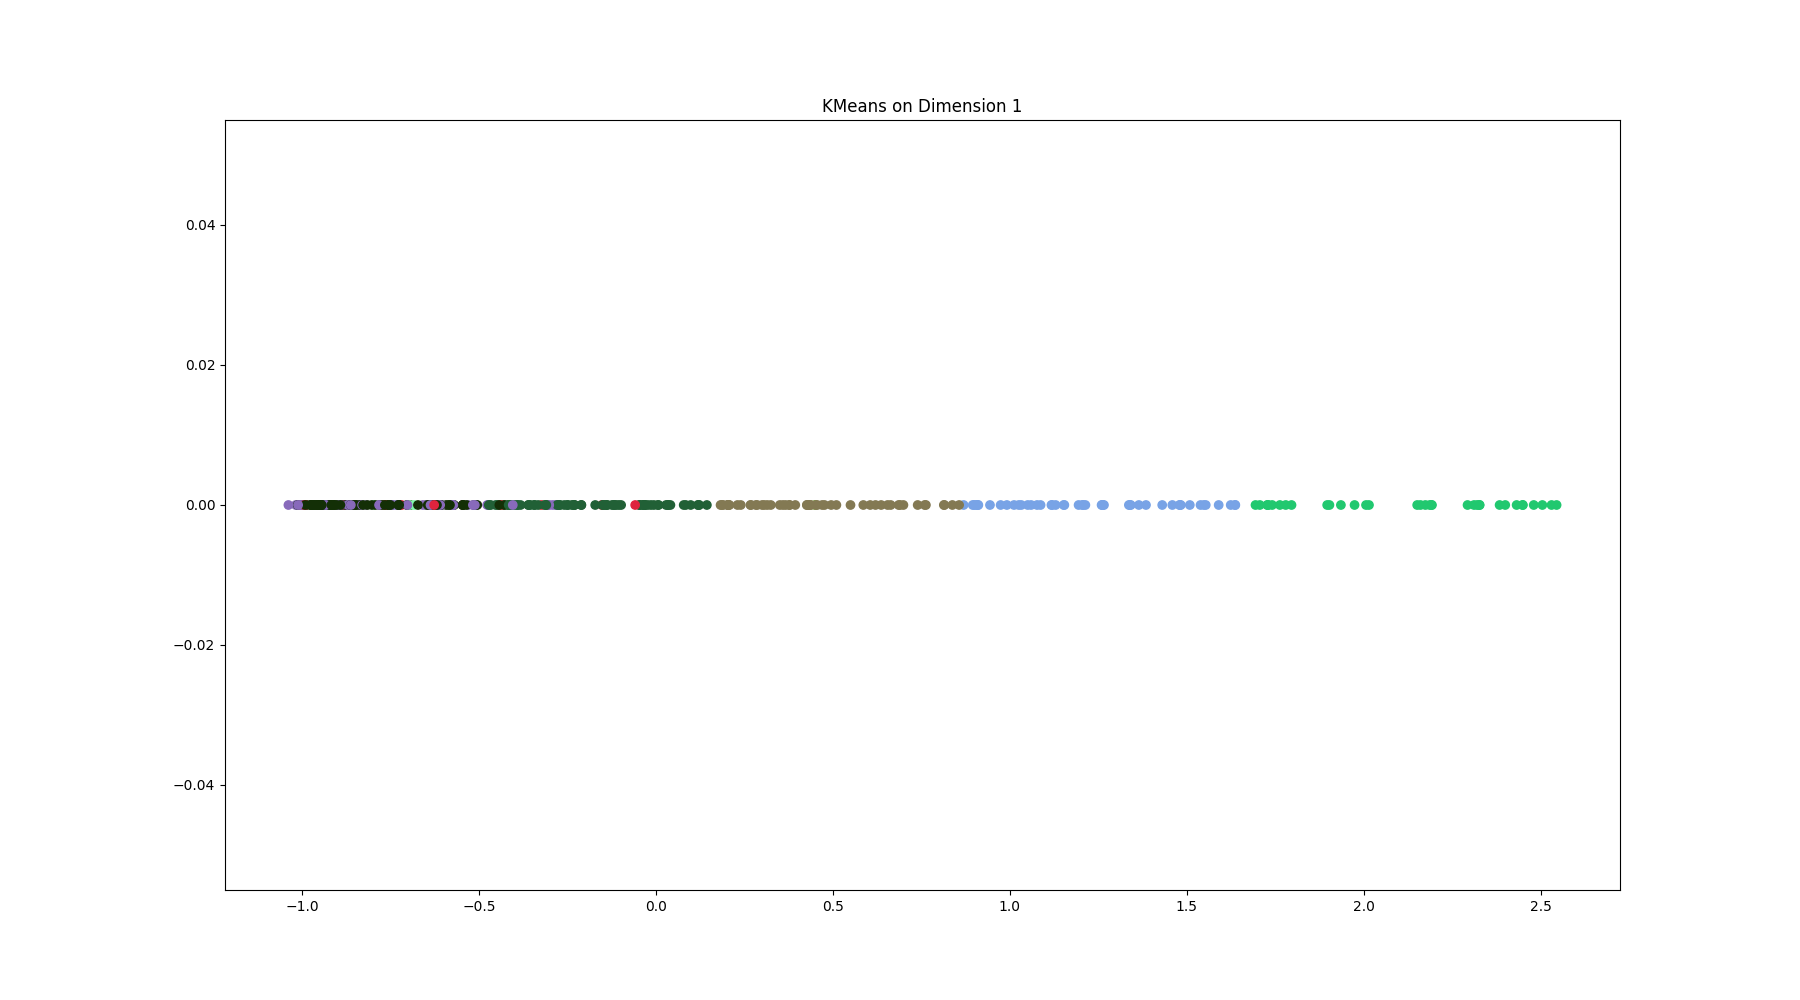

In [6]:
plot_axis(0)

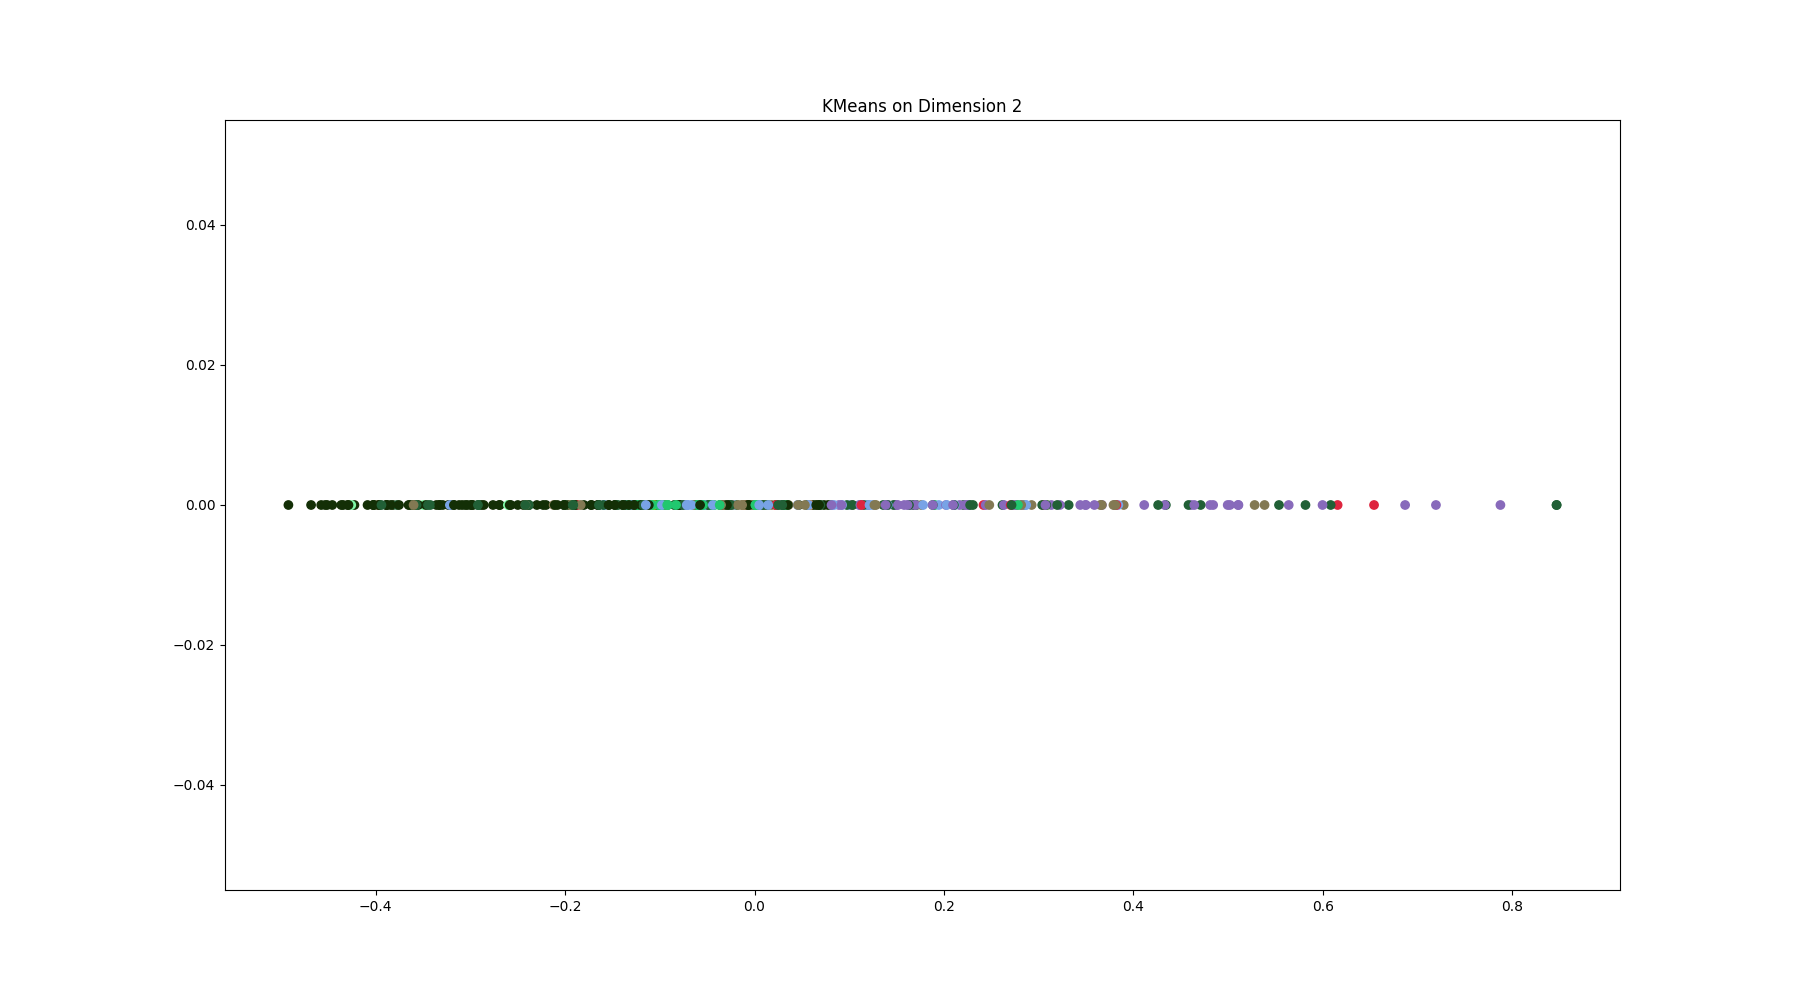

In [7]:
plot_axis(1)

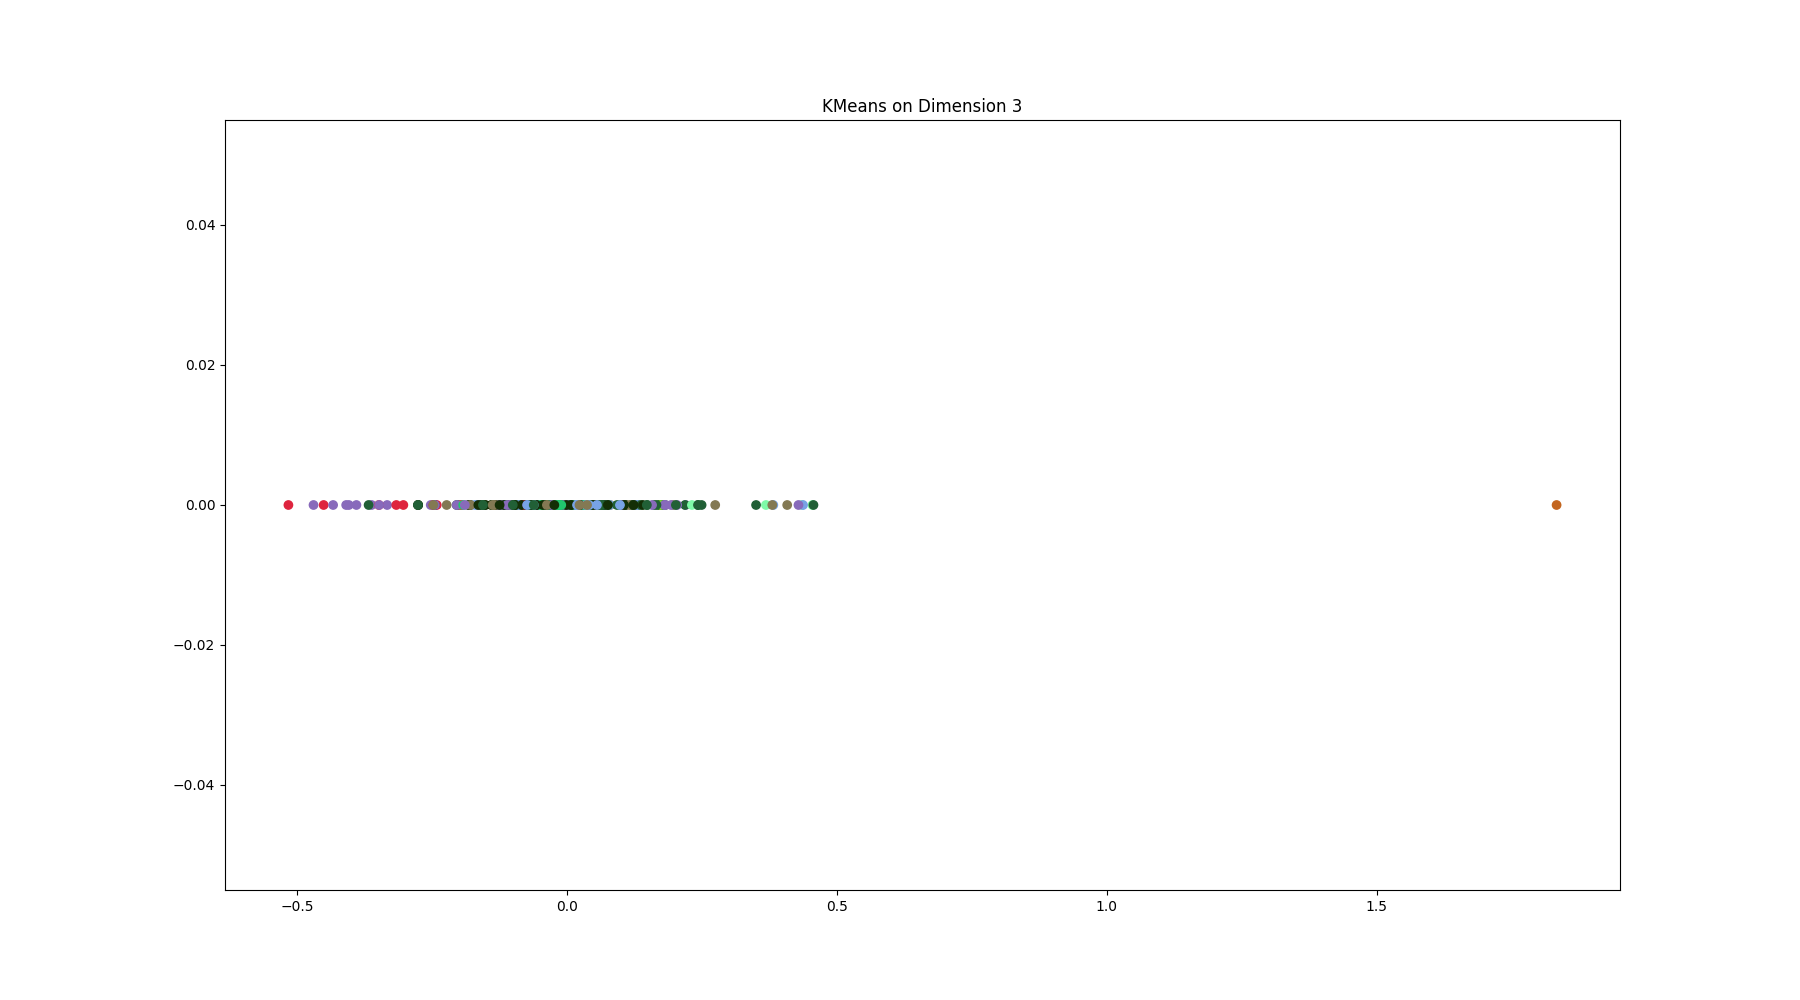

In [8]:
plot_axis(2)

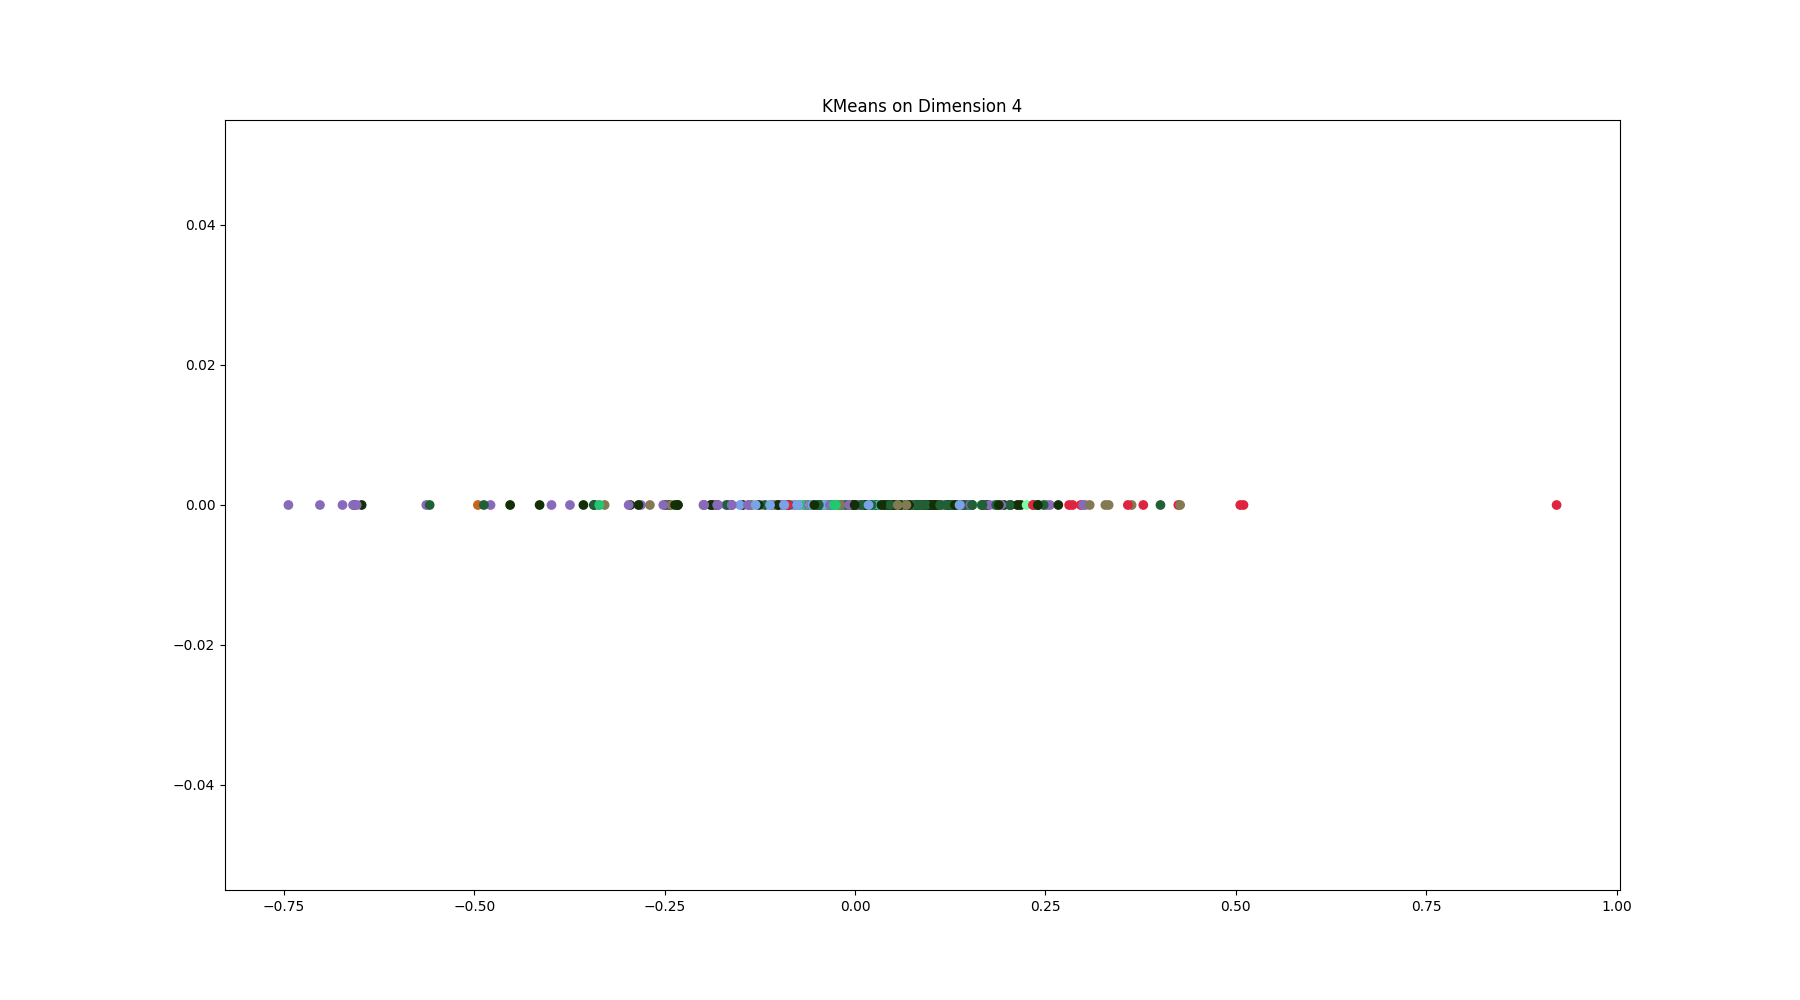

In [9]:
plot_axis(3)

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


In [12]:
import cluster

def get_theorems_in_group(group, max_size=None, random=True):
	s = [embeddings[i][0] for i in np.where(label == group)[0]]
	if max_size is None or len(s) <= max_size: 
		return s
	if not random:
		return s[:max_size]
	c = np.random.choice(np.arange(len(s)), size=max_size, replace=False)
	return [s[i] for i in c]

MAX_SIZE=20
# rel_0_1  = cluster.relative_labels(get_theorems_in_group(0, max_size=MAX_SIZE), get_theorems_in_group(1, max_size=MAX_SIZE), api_key=OPENAI_API_KEY)

In [14]:
def get_all_differences():
	differences = []
	for i in range(N_CLUSTERS):
		for j in range(i):
			print(i, j)
			diffs = cluster.relative_labels(get_theorems_in_group(0, max_size=MAX_SIZE), get_theorems_in_group(6, max_size=MAX_SIZE), i, j, api_key=OPENAI_API_KEY)
			print(diffs)
			differences.append((i, j, diffs))
	return differences
j = {}
j['differences'] = get_all_differences()
# j['differences'] = differences

1 0
Set Cluster 1 contains theorems about various mathematical structures and their properties, while Set Cluster 0 focuses on theorems related to order relations, inequalities, and set operations.
2 0
Set Cluster 2 focuses heavily on lemmas and theorems involving more complex mathematical concepts and group theory including equalities, boundaries, mapping, and multiplicative properties. Set Cluster 0 displays more in propositions, boolean logic, inequality, minimax values, division, multiplication, and casting operations.
2 1
The main difference between the two sets is that the theorems in Cluster 1 are primarily related to mathematical operations and logical statements involving equality, inequality, and membership, whereas the theorems in Cluster 2 incorporate more advanced mathematical concepts such as sorting algorithms, morphisms, and surjectivity.
3 0
The main difference between these two clusters is that the theorems in Cluster 3 primarily concern themselves with structures and

In [15]:
j['theorems'] = [[
				[lab, embeddings[idx][0]] for idx in np.where(label == lab)[0].tolist()
		  ] for lab in range(N_CLUSTERS)]
# get_all_differences()

In [16]:
json.dump(j, open(f"data_store/differences_clustersize_{N_CLUSTERS}_seed_{SEED}.json", "w"))

## Assign a final label based off of differences

In [20]:
from langchain import OpenAI


def get_label(centroid_idx: int, differences: List[Tuple[int, int, str]]):
	related_diffs = []
	for i, j, diffs in differences:
		if i == centroid_idx or j == centroid_idx:
			related_diffs.append(diffs)
	label = "Set Cluster " + str(centroid_idx)
	prompt = "Given the following differences between different sets of two cluster, what is the primary focus of " + label + """ in one sentence?

""" + "\n".join(related_diffs) + """

PRIMARY FOCUS:"""
	llm = OpenAI(model_name="gpt-4", openai_api_key=OPENAI_API_KEY)
	ret = llm(prompt)
	return ret


'Set Cluster 2 primarily focuses on advanced mathematical concepts and group theory, covering topics such as lemmas and theorems, equalities, boundaries, mapping, and multiplicative properties.'

In [21]:
llm_labels = []
for i in range(N_CLUSTERS):
	llm_labels.append(get_label(i, j['differences']))
j["llm_labels"] = llm_labels
json.dump(j, open(f"data_store/differences_clustersize_{N_CLUSTERS}_seed_{SEED}.json", "w"))

/home/lev/.local/lib/python3.9/site-packages/langchain/llms/openai.py:200: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/home/lev/.local/lib/python3.9/site-packages/langchain/llms/openai.py:787: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
